In [525]:
print(1+2)

3


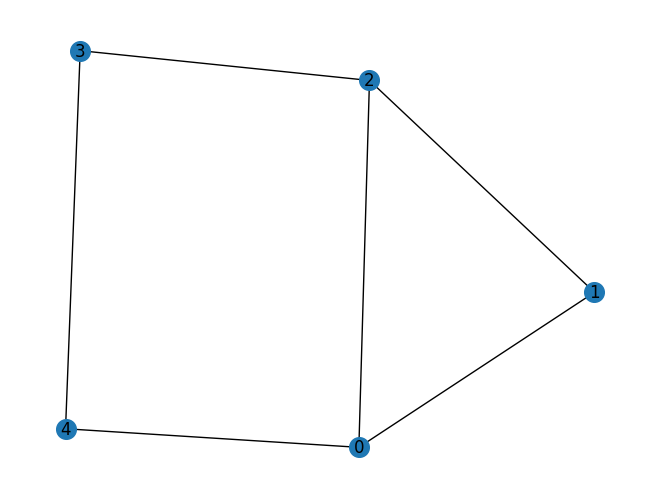

In [526]:
# ============================================================
# STEP 1: Build rustworkx graph for MaxCut
# ============================================================

import numpy as np
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import matplotlib.pyplot as plt
import matplotlib


n = 5
G = rx.PyGraph()
G.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1),
    (0, 2, 1),
    (0, 4, 1),
    (1, 2, 1),
    (2, 3, 1),
    (3, 4, 1),
]
G.add_edges_from(edge_list)
draw_graph(G, node_size=200, with_labels=True)
plt.show()

In [527]:
# ============================================================
# STEP 2: Build cost Hamiltonian as SparsePauliOp
# ============================================================

from qiskit.quantum_info import SparsePauliOp

def build_pauli(graph: rx.PyGraph):
    pauli_list = []
    for u, v in graph.edge_list():
        w = graph.get_edge_data(u, v)
        w = float(w)
        pauli_list.append(("ZZ", [u, v], w))
    return pauli_list

maxcut_paulis = build_pauli(G)
cost_hamiltonian = SparsePauliOp.from_sparse_list(maxcut_paulis, n)

print("\nCost function Hamiltonian:")
print(cost_hamiltonian)


Cost function Hamiltonian:
SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])



QAOA ansatz:


/Users/shyam/Documents/Quantum Projects/qiskit_venv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


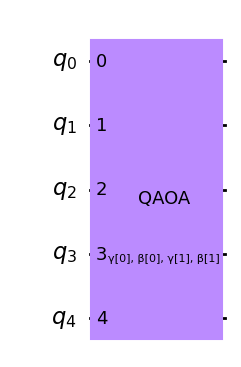

In [528]:
# ============================================================
# STEP 3: Build QAOA ansatz
# ============================================================

from qiskit.circuit.library import QAOAAnsatz

reps = 2
ansatz = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)

print("\nQAOA ansatz:")
ansatz.draw("mpl")

In [529]:
print("Number of parameters in ansatz:", ansatz.num_parameters)
print(ansatz.parameters)

Number of parameters in ansatz: 4
ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])


In [530]:
# ============================================================
# STEP 4: Define cost function using local Estimator
# ============================================================

from qiskit.primitives import Estimator
estimator = Estimator()

objective_values = []

def cost_func(params):
    job = estimator.run(
        circuits=[ansatz],
        observables=[cost_hamiltonian],
        parameter_values=[params],
    )
    result = job.result()
    cost = float(result.values[0])
    objective_values.append(cost)
    return cost


initial_params = np.random.uniform(0, 2 * np.pi, size=ansatz.num_parameters)
print("\nInitial params:", initial_params)


Initial params: [5.15375407 1.87808982 4.42093776 2.28158851]



=== Optimization Result ===
Success: False
Message: Return from COBYLA because the objective function has been evaluated MAXFUN times.
Optimal parameters: [4.78924152 2.79623097 4.35526738 2.247658  ]
Optimal cost: -2.2695027478615533


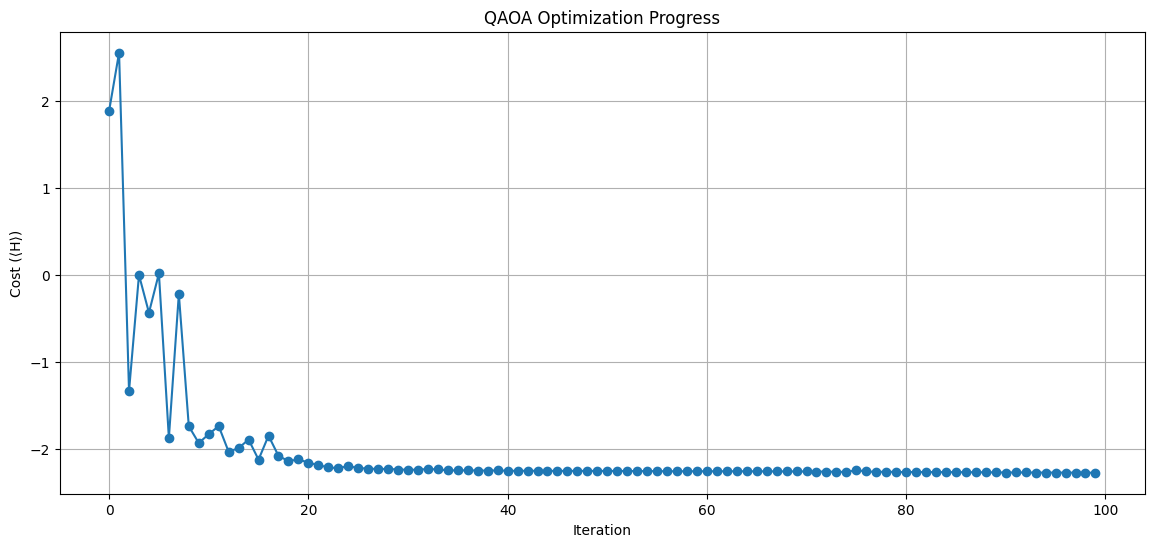

In [531]:
# ============================================================
# STEP 5: Classical optimization (COBYLA via SciPy)
# ============================================================

from scipy.optimize import minimize

opt_result = minimize(
    cost_func,
    initial_params,
    method="COBYLA",
    options={"maxiter": 100},
)

print("\n=== Optimization Result ===")
print("Success:", opt_result.success)
print("Message:", opt_result.message)
print("Optimal parameters:", opt_result.x)
print("Optimal cost:", opt_result.fun)

# Plot cost vs iterations
plt.figure(figsize=(14, 6))
plt.plot(objective_values, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Cost (⟨H⟩)")
plt.title("QAOA Optimization Progress")
plt.grid(True)
plt.show()



Optimized circuit with measurements:


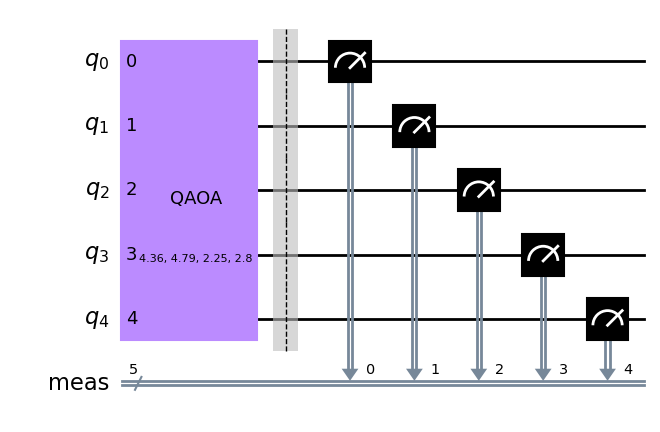

In [532]:
opt_circuit = ansatz.assign_parameters(opt_result.x)
opt_circuit_meas = opt_circuit.copy()
opt_circuit_meas.measure_all()

print("\nOptimized circuit with measurements:")
opt_circuit_meas.draw("mpl")

In [533]:
# ============================================================
# STEP 6: Measure optimized circuit with AerSimulator
# ============================================================

from qiskit_aer import AerSimulator
from qiskit import transpile


backend = AerSimulator()
t_circ = transpile(opt_circuit_meas, backend)
job = backend.run(t_circ, shots=2048)
counts = job.result().get_counts()

print("\nMeasurement counts (bitstrings):")
print(counts)





Measurement counts (bitstrings):
{'01000': 2, '00010': 6, '00100': 9, '11000': 9, '11111': 4, '00000': 4, '11010': 149, '00001': 17, '00011': 33, '01100': 45, '10000': 1, '11001': 41, '10001': 59, '00111': 16, '10100': 217, '10010': 102, '11100': 46, '01010': 133, '01111': 4, '01110': 57, '10011': 58, '10111': 4, '01101': 138, '10101': 137, '00101': 136, '11011': 13, '01001': 162, '11101': 2, '00110': 37, '10110': 196, '11110': 19, '01011': 192}


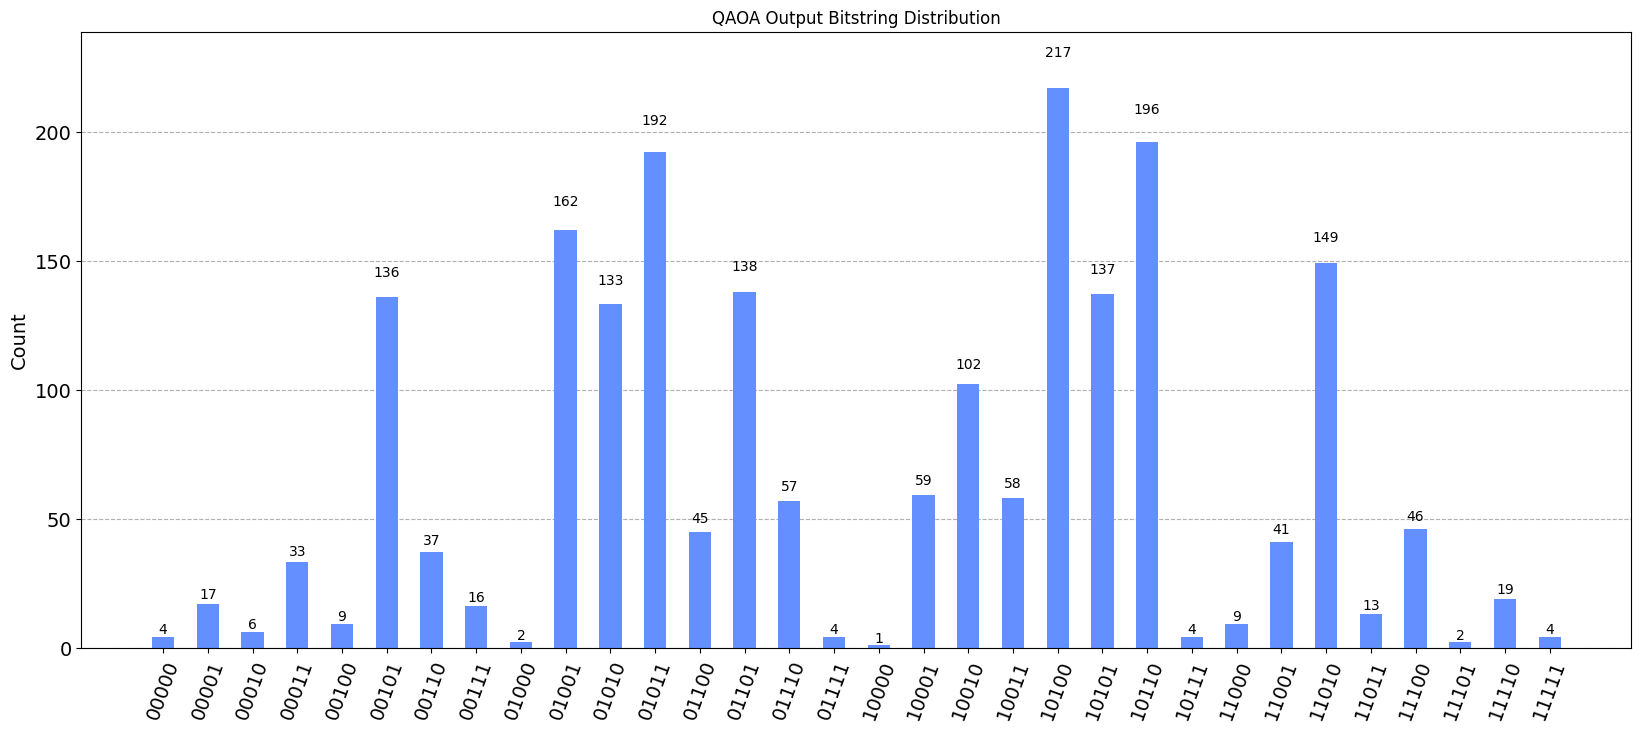

In [534]:
from qiskit.visualization import plot_histogram
plot_histogram(counts, title="QAOA Output Bitstring Distribution", figsize=(20, 8))


In [535]:
# Most likely bit string
# ------------------------------------

final_distribution_int = {}
for bitstring, c in counts.items():
    value = int(bitstring, 2)
    final_distribution_int[value] = c

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(d) for d in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())

# Index of max probability
most_likely_index = np.argmax(values)

most_likely_int = keys[most_likely_index]
most_likely_bitstring = to_bitstring(most_likely_int, n)

# Reverse to match qubit ordering (Qiskit's MSB/LSB convention)
most_likely_bitstring.reverse()

print("Most likely bitstring:", most_likely_bitstring)


Most likely bitstring: [0, 0, 1, 0, 1]


In [536]:
# Normalize counts into probabilities
total = sum(counts.values())
final_distribution_bin = {bs: c / total for bs, c in counts.items()}


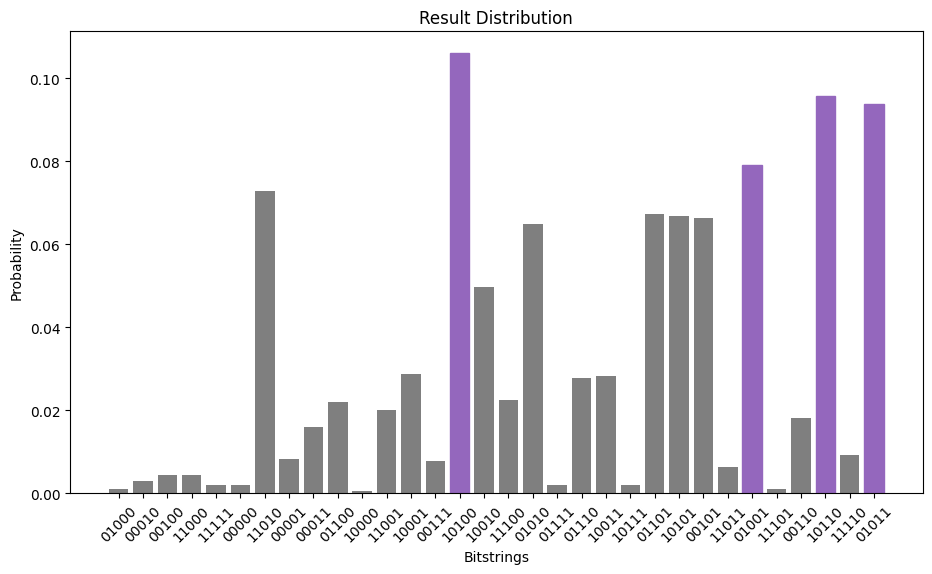

In [537]:
# Highlight top-4 bars
# ------------------------------------

matplotlib.rcParams.update({"font.size": 10})

values = np.array(list(final_distribution_bin.values()))
bitstrings = list(final_distribution_bin.keys())

# Top 4 probabilities
top4_indices = values.argsort()[-4:]

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)

plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings")
plt.ylabel("Probability")

bars = ax.bar(bitstrings, values, color="tab:grey")
for idx in top4_indices:
    bars[idx].set_color("tab:purple")

plt.show()


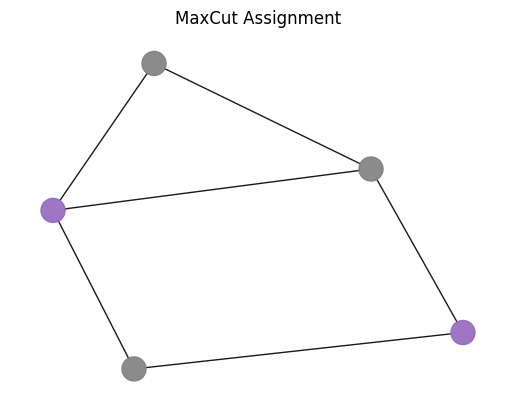

In [538]:
# Visualize max-cut partition
# ------------------------------------
def plot_result(G, x):
    colors = ["tab:grey" if bit == 0 else "tab:purple" for bit in x]

    pos = rx.spring_layout(G)
    fig, ax = plt.subplots()
    rx.visualization.mpl_draw(
        G,
        node_color=colors,
        node_size=300,
        alpha=0.9,
        pos=pos,
        ax=ax
    )
    plt.title("MaxCut Assignment")
    plt.show()

plot_result(G, most_likely_bitstring)


In [539]:
# Compute max-cut values
# ------------------------------------
from typing import Sequence

def evaluate_sample(x: Sequence[int], graph: rx.PyGraph) -> float:
    assert len(x) == len(graph.nodes())

    cut_value = 0
    for u, v in graph.edge_list():
        cut_value += x[u] * (1 - x[v]) + x[v] * (1 - x[u])
    return cut_value

cut_value = evaluate_sample(most_likely_bitstring, G)
print("MaxCut value:", cut_value)


MaxCut value: 5
